In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import laplace_asymmetric
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
#import dataset
df_complete = pd.read_excel('EA_GDP.xlsx')
df_complete.head()


,TIME,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1991Q1,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1991Q2,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1991Q3,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1991Q4,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1992Q1,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [3]:
df = df_complete.drop('TIME', axis=1)
df.head()

,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [4]:
rgdp = df['RGDP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 
rgdp_an = df['GDPgrowth(annualized)'].values.astype(float) 
rgdp_growth = df['GDPgrowth/400'].values.astype(float) 

rgdp_lag = np.roll(rgdp_an, 1)
rgdp_lag[0] = 0
rgdp_lag_growth = np.roll(rgdp_growth, 1)
rgdp_lag_growth[0] = 0

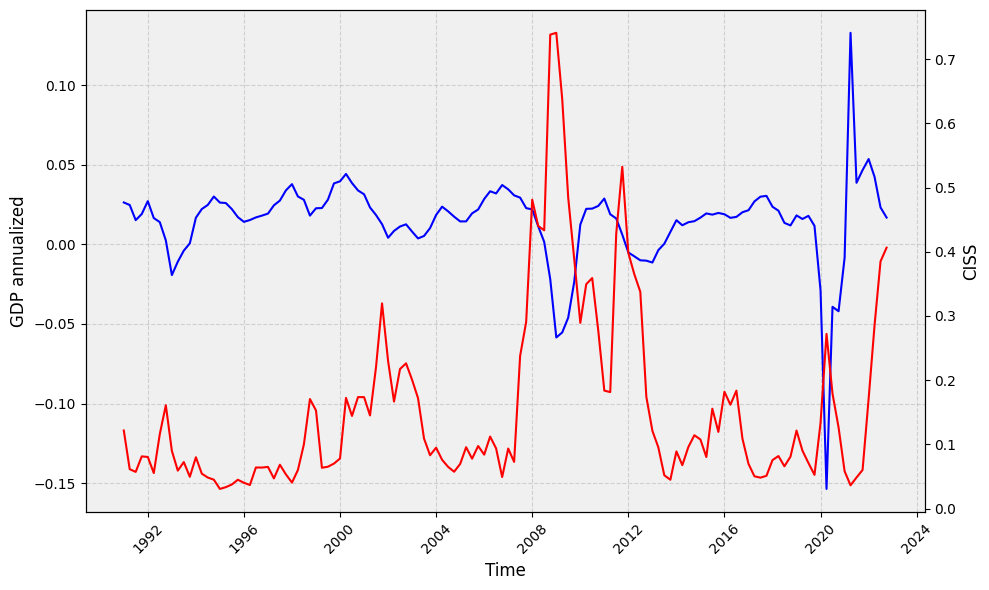

In [5]:
# Convert 'TIME' column to datetime
df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])

# Create the fancy plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_complete['TIME'], df_complete['GDPgrowth(annualized)'], linestyle='-', color='b')

# Set plot title and labels
#ax.set_title('GDP Time Series and CISS', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('GDP annualized', fontsize=12)

# Customize the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45, labelsize=10)
# Create a twin Axes for the secondary y-axis
ax2 = ax.twinx()
ax2.plot(df_complete['TIME'], df_complete['CISS'], linestyle='-', color='r')
ax2.set_ylabel('CISS', fontsize=12)
# Add gridlines
ax.grid(True, linestyle='--', alpha=0.5)

# Add a background color to the plot
ax.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()


In [6]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(rgdp_an), rgdp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(rgdp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(rgdp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(rgdp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary()) 


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4648
Model:                       QuantReg   Bandwidth:                    0.004994
Method:                 Least Squares   Sparsity:                      0.03425
Date:                Sun, 02 Jul 2023   No. Observations:                  128
Time:                        16:26:37   Df Residuals:                      125
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.472      0.638      -0.003       0.004
x1             0.8133      0.052     15.634      0.000       0.710       0.916
x2            -0.0325      0.008     -4.157      0.000      -0.048      -0.017
                         QuantReg Regression Results

In [8]:
#Autocorrelation paramter estimation PACKAGE 0.1, 0.5, 0.9
beta_pac1 = np.array([0.0009, 0.8133, -0.0325])  
beta_pac5 = np.array([0.0077, 0.7821, -0.0271])  
beta_pac9 = np.array([0.0256, 0.3915, -0.0261])  

ε = rgdp_an - X @ beta_pac1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 0.1= ", theta_hat)

ε = rgdp_an - X @ beta_pac5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 0.5= ", theta_hat)

ε = rgdp_an - X @ beta_pac9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho PAC 9= ", theta_hat)

rho PAC 0.1=  [[-0.10024148]]
rho PAC 0.5=  [[-0.20725433]]
rho PAC 9=  [[0.40353307]]


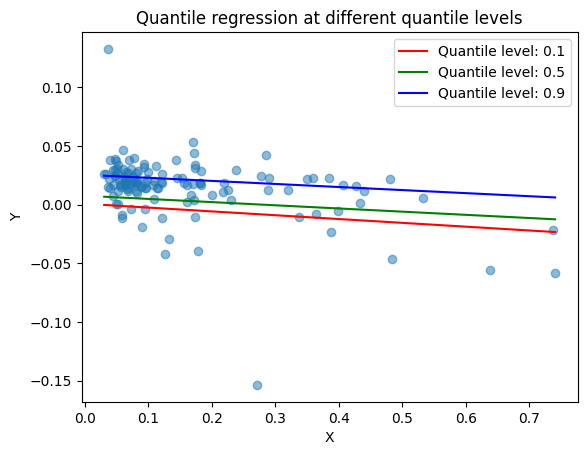

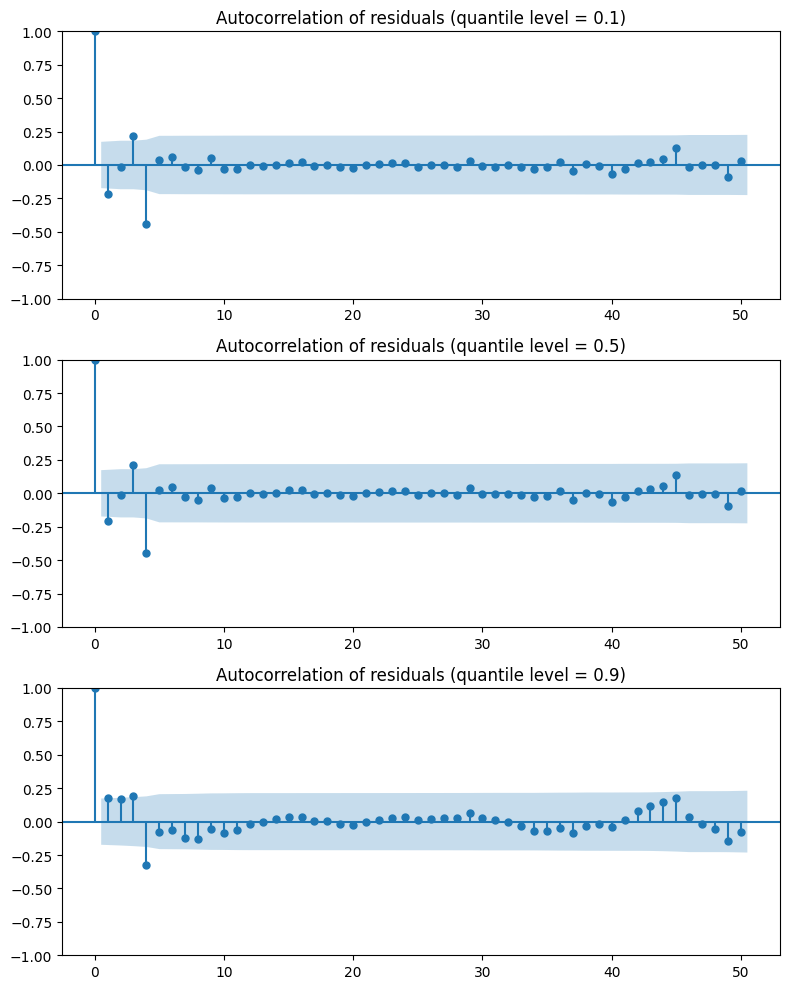

In [9]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, rgdp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(rgdp_lag), np.max(rgdp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

In [44]:
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)

      lb_stat     lb_pvalue
1    6.367790  1.162103e-02
2    6.409466  4.056973e-02
3   12.858613  4.952557e-03
4   39.111716  6.605936e-08
5   39.275740  2.089869e-07
6   39.774218  5.044979e-07
7   39.795657  1.377365e-06
8   40.018515  3.178378e-06
9   40.357593  6.544687e-06
10  40.512653  1.376055e-05
11  40.640925  2.778095e-05
12  40.641736  5.623738e-05
13  40.646325  1.087236e-04
14  40.647177  2.020846e-04
15  40.696604  3.556747e-04
16  40.750632  6.043200e-04
17  40.765981  1.007977e-03
18  40.767175  1.639054e-03
19  40.803225  2.563315e-03
20  40.872907  3.867740e-03
21  40.874148  5.811481e-03
22  40.881481  8.512780e-03
23  40.924259  1.208065e-02
24  40.975046  1.676227e-02
25  41.016656  2.286491e-02
26  41.017959  3.090524e-02
27  41.019606  4.100752e-02
28  41.053128  5.310641e-02
29  41.236402  6.565983e-02
30  41.248352  8.286158e-02
31  41.277542  1.026794e-01
32  41.279938  1.260418e-01
33  41.321054  1.516123e-01
34  41.466028  1.772042e-01
35  41.515798  2.078

In [ ]:
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

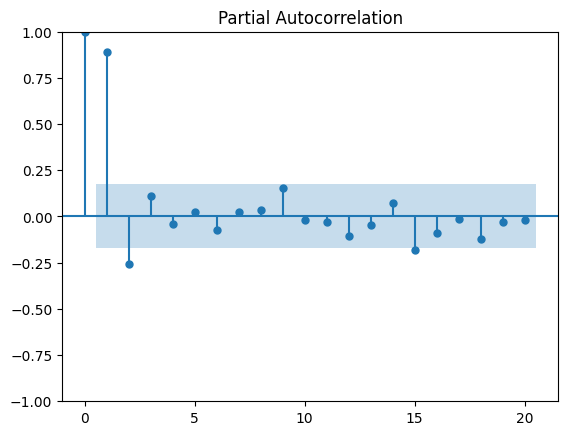

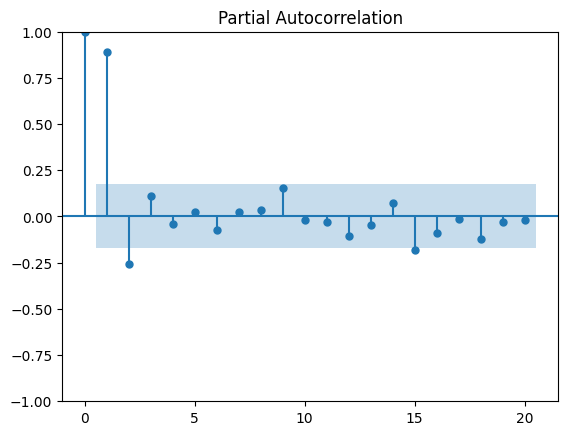

In [13]:
# Plot PACF of the time series
plot_pacf(ciss, lags=20)

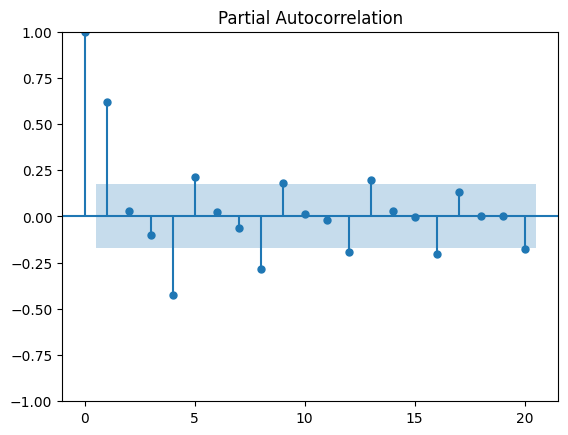

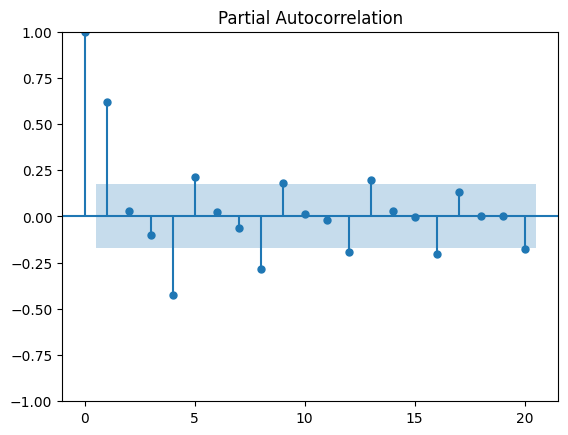

In [14]:
plot_pacf(rgdp_an, lags=20)

In [33]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        εg = y - X @ beta_gls
        εg = ε.reshape((-1, 1))
        ε_lagg = np.roll(εg, 1)
        ε_lagg[0] = 0
        ε_lagg = ε_lagg.reshape((-1, 1))
        theta_gls = np.linalg.inv(ε_lagg.T @ ε_lagg) @ ε_lagg.T @ εg
        #theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


In [34]:
M=128
initial_params = 0.0077, 0.7821, -0.0271, 1, 0.0077, 0.7821, -0.0271, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.14838298464622607]
OLS beta_hat:  [-0.03524024167890109]
OLS gamma_hat:  [-0.6125841528685614]
OLS theta_hat:  [-0.004539548348578233]
GLS alpha_hat:  [0.14804702644683873]
GLS beta_hat:  [-0.030899676187180737]
GLS gamma_hat:  [-0.611625585723887]
GLS theta_hat:  [-0.004539548348578233]


In [ ]:
#Autocorrelation parameter estimation OLS
beta_ols5 = np.array([0.1484, -0.0352, -0.6126])  
beta_gls5 = np.array([0.1481, -0.0309, -0.6116])  

ε = rgdp_an - X @ beta_ols5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho OLS 0.5 = ", theta_hat)

ε = rgdp_an - X @ beta_gls5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho GLS 0.5 = ", theta_hat)

ASYMMETRIC LAPLACE ESTIMATION

In [46]:
def Laplace_estimation(df, p, M, params0):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        ll -= np.sum(np.log(np.sqrt(1/z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Powell')  # minimize the negative log-likelihood #method='Powell'
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1
        
    #print("Beta Matrix:")
    #print(beta_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))


    return beta_matrix


In [47]:
#Estimation at p=0.9 LA1
params1 = np.array([0.0009, 0.8133, -0.0325], dtype=float)
result_matrix = Laplace_estimation(df, 0.1, 1000, params1)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.13444595  0.14752615  1.15108186]


In [49]:
#Estimation at p=0.5 LAP
params5 = np.array([0.0009, 0.8133, -0.0325], dtype=float)#initial parametrs from OLS package p=0.5 
result_matrix = Laplace_estimation(df, 0.5, 1000, params5)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.14484332  0.12767322  0.90000272]


In [50]:
#Estimation at p=0.9 LAP
params9 = np.array([0.0256, 0.3915, -0.0261], dtype=float)#initial parametrs from OLS package p=0.9
result_matrix = Laplace_estimation(df, 0.5, 1000, params9)


Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[-0.15033283  0.05363187  0.80014178]


In [48]:
#Autocorrelation parameter estimation ASYMMETRIC LAPLACE p=0.1, 0.5, 0.9
beta_lap1 = np.array([-0.1344, 0.1475, 1.1511])  
beta_lap5 = np.array([-0.1448, 0.1277, 0.9000])  
beta_lap9 = np.array([-0.1503, 0.0536, 0.8001])  
ε = rgdp_an - X @ beta_lap1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.1 = ", theta_hat)

ε = rgdp_an - X @ beta_lap5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.5 = ", theta_hat)

ε = rgdp_an - X @ beta_lap9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho LAP 0.9 = ", theta_hat)

rho LAP 0.1 =  [[0.89600892]]
rho LAP 0.5 =  [[0.88462622]]
rho LAP 0.9 =  [[0.88953083]]


EM ALGORITHM ESTIMATION

In [51]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y_dataset = df['GDPgrowth(annualized)'].values
    #T = min(M, len(y_dataset))
    T = len(y_dataset)
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = np.array(y)
    x = np.array(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)

        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))

        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse

        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

    #return β_values

In [52]:
#EM algorithm estimation p=0.1
n = 128
p = 0.1
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0009, 0.8133, -0.0325]) #input result of PAC
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-2781.33189422   -38.10181798  -460.21585073]
Iteration 2: [-0.17743224 -0.0025037  -0.02780954]
Iteration 3: [-0.16771975  0.91913418 -0.08612163]
Iteration 4: [-0.16762217  0.91883251 -0.08667687]
Iteration 5: [-0.16784685  0.92199386 -0.08627103]
Iteration 6: [-0.16792145  0.92379524 -0.08613262]
Iteration 7: [-0.16838487  0.92250941 -0.08545619]
Iteration 8: [-0.167987    0.92092344 -0.08602055]
Iteration 9: [-0.16892643  0.93550412 -0.08437123]
Iteration 10: [-0.16976273  0.95680558 -0.08264501]
Iteration 11: [-0.16793672  0.91005853 -0.08639918]
Iteration 12: [-0.16982304  0.95669827 -0.08253347]


In [53]:
#EM algorithm estimation p=0.5
n = 128
p = 0.5
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0077, 0.7821, -0.0271]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-148.33371801   39.53262748 -512.57600702]
Iteration 2: [ 7.00238027e-05  7.87666748e-03 -4.97497228e-04]
Iteration 3: [  0.97329943 109.02957115  -6.89033438]
Iteration 4: [ 0.00797149  0.90415684 -0.05695719]
Iteration 5: [ 0.00823102  0.95096721 -0.05966405]
Iteration 6: [ 0.00809171  0.92560271 -0.05830154]
Iteration 7: [ 0.00775109  0.92981731 -0.05777861]
Iteration 8: [ 0.00840048  0.92739812 -0.05874798]
Iteration 9: [ 0.00812377  0.93130051 -0.05827318]
Iteration 10: [ 0.00786373  0.93762323 -0.05774636]
Iteration 11: [ 0.00932388  0.90244187 -0.06069411]
Iteration 12: [ 0.00707375  0.95584472 -0.05617292]


In [54]:
#EM algorithm estimation p=0.9
n = 128
p = 0.9
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([0.0256, 0.3915, -0.0261]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [2766.79416909   42.03940184  409.23881757]
Iteration 2: [0.17885415 0.00264322 0.02802469]
Iteration 3: [ 0.18611741  0.92479636 -0.0308301 ]
Iteration 4: [ 0.18604304  0.92337113 -0.0311409 ]
Iteration 5: [ 0.18582425  0.92656598 -0.0307447 ]
Iteration 6: [ 0.18574589  0.92848815 -0.03060007]
Iteration 7: [ 0.18528218  0.92702877 -0.02992338]
Iteration 8: [ 0.18564838  0.92546483 -0.03047376]
Iteration 9: [ 0.18467663  0.94049722 -0.02878336]
Iteration 10: [ 0.18380144  0.96257232 -0.02700207]
Iteration 11: [ 0.18565177  0.91503923 -0.03080803]
Iteration 12: [ 0.18374275  0.96147114 -0.02697366]


In [56]:
#Autocorrelation parameter estimation EM  p=0.1, 0.5, 0.9
beta_em1 = np.array([-0.1674, 0.9102, -0.0863])
beta_em5 = np.array([0.0079, 0.9379, -0.0578])  
beta_em9 = np.array([0.1833, 0.9629, -0.0270])  
ε = rgdp_an - X @ beta_em1
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.1 = ", theta_hat)

ε = rgdp_an - X @ beta_em5
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.5 = ", theta_hat)

ε = rgdp_an - X @ beta_em9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(f"rho EM 0.9 = ", theta_hat)

rho EM 0.1 =  [[0.98241985]]
rho EM 0.5 =  [[-0.1802731]]
rho EM 0.9 =  [[0.98163715]]


FORECASTING

In [58]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    return mse_list


In [59]:
df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([-0.1448, 0.1277, 0.9000])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
beta_pac = np.array([0.0077, 0.7821, -0.0271])  

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls', 'beta_pac']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MFSE for {beta_name}, horizon {horizon}: {avg_mse}")


Average MFSE for beta_lap, horizon 1: 0.021445777113212227
Average MFSE for beta_lap, horizon 2: 0.02128545631857164
Average MFSE for beta_lap, horizon 3: 0.021156818396377123
Average MFSE for beta_lap, horizon 4: 0.02110825974030198
Average MFSE for beta_lap, horizon 5: 0.021108100924956175
Average MFSE for beta_lap, horizon 6: 0.02111248719720943
Average MFSE for beta_lap, horizon 7: 0.021120177354430232
Average MFSE for beta_lap, horizon 8: 0.02108587330335599
Average MFSE for beta_em, horizon 1: 0.0012810884368658253
Average MFSE for beta_em, horizon 2: 0.0012829152639213472
Average MFSE for beta_em, horizon 3: 0.0012870880316507777
Average MFSE for beta_em, horizon 4: 0.0012901569264238146
Average MFSE for beta_em, horizon 5: 0.0012941218382557438
Average MFSE for beta_em, horizon 6: 0.0013013782164665783
Average MFSE for beta_em, horizon 7: 0.0013101718067763464
Average MFSE for beta_em, horizon 8: 0.0012916399379065454
Average MFSE for beta_ols, horizon 1: 0.008083100651312309
A

In [8]:
import numpy as np
from scipy.stats import norm

def diebold_mariano_test(errors1, errors2, h=1):
    n = len(errors1)
    d = np.abs(errors1) - np.abs(errors2)
    s = np.var(d)
    test_statistic = np.mean(d) / np.sqrt((1 / n) * s)
    p_value = 2 * (1 - norm.cdf(np.abs(test_statistic)))
    return test_statistic, p_value

# Define the forecast errors for each model
lap_errors = [0.0011139697285139102, 0.0011195670635388794, 0.0011258108459036725, 0.0011298776185967373,
              0.0011337497767893844, 0.0011399451012437012, 0.0011474594187636214, 0.0011313296533233624]

em_errors = [0.0012810884368658253, 0.0012829152639213472, 0.0012870880316507777, 0.0012901569264238146,
             0.0012941218382557438, 0.0013013782164665783, 0.0013101718067763464, 0.0012916399379065454]

gls_errors = [0.008053194712855028, 0.00800790897973031, 0.007967344620219363, 0.007947758770003113,
              0.007948306502827851, 0.007954888859141003, 0.00796287600625178, 0.007980016110644174]

ols_errors = [0.008083100651312309, 0.00803795071509084, 0.00799745002579299, 0.007977899923605206,
              0.00797847685691496, 0.007985066717916385, 0.007993068620486824, 0.0080103691390461]

# Perform Diebold-Mariano test for Lap model vs. OLS model
dm_lap_ols = diebold_mariano_test(lap_errors, ols_errors)
print("Diebold-Mariano test for Lap vs. OLS:")
print("Test Statistic:", dm_lap_ols[0])
print("p-value:", dm_lap_ols[1])
print()

# Perform Diebold-Mariano test for EM model vs. OLS model
dm_em_ols = diebold_mariano_test(em_errors, ols_errors)
print("Diebold-Mariano test for EM vs. OLS:")
print("Test Statistic:", dm_em_ols[0])
print("p-value:", dm_em_ols[1])
print()

# Perform Diebold-Mariano test for GLS model vs. OLS model
dm_gls_ols = diebold_mariano_test(gls_errors, ols_errors)
print("Diebold-Mariano test for GLS vs. OLS:")
print("Test Statistic:", dm_gls_ols[0])
print("p-value:", dm_gls_ols[1])


Diebold-Mariano test for Lap vs. OLS:
Test Statistic: -463.16164975051583
p-value: 0.0

Diebold-Mariano test for EM vs. OLS:
Test Statistic: -473.02879227473653
p-value: 0.0

Diebold-Mariano test for GLS vs. OLS:
Test Statistic: -707.8114925587232
p-value: 0.0


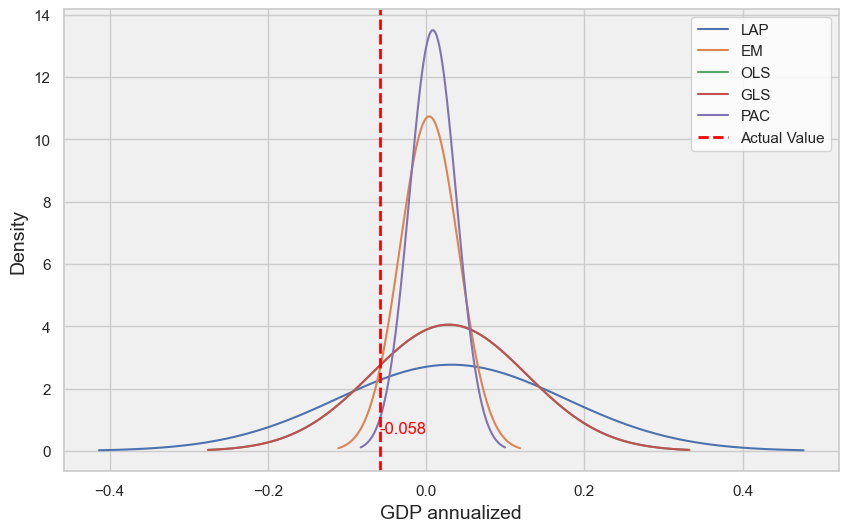

In [60]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []
    predictive_densities = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        if horizon == 1 and vintage == np.datetime64('2008-10-01'):
            predictive_density = norm(loc=np.mean(y_forecast), scale=np.std(y_forecast))
            predictive_densities.append(predictive_density)

    return mse_list, predictive_densities


df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizon = 1

#beta_lap = np.array([0.0009, 0.8211, -0.0327]) 
beta_lap = np.array([-0.1448, 0.1277, 0.9000])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
beta_pac = np.array([0.0077, 0.7821, -0.0271])  

#betas = [beta_lap, beta_em, beta_ols, beta_gls]
#beta_names = ['LAP', 'EM', 'OLS', 'GLS']

betas = [beta_lap, beta_em, beta_ols, beta_gls, beta_pac]
beta_names = ['LAP', 'EM', 'OLS', 'GLS', 'PAC']


models = len(betas)

# Select the vintage for the plot
vintage = np.datetime64('2009-01-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'GDPgrowth(annualized)']
#ax.text(actual_value, 0.05, f'Actual Value: {actual_value:.3f}', color='red', fontsize=12, ha='center', va='center')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')


ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
# Add a background color to the plot
ax.set_facecolor('#f0f0f0')
# Set the plot title and labels
#ax.set_title(f'Predictive Densities for Vintage 2009-Q1', fontsize=16)
ax.set_xlabel('GDP annualized', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()


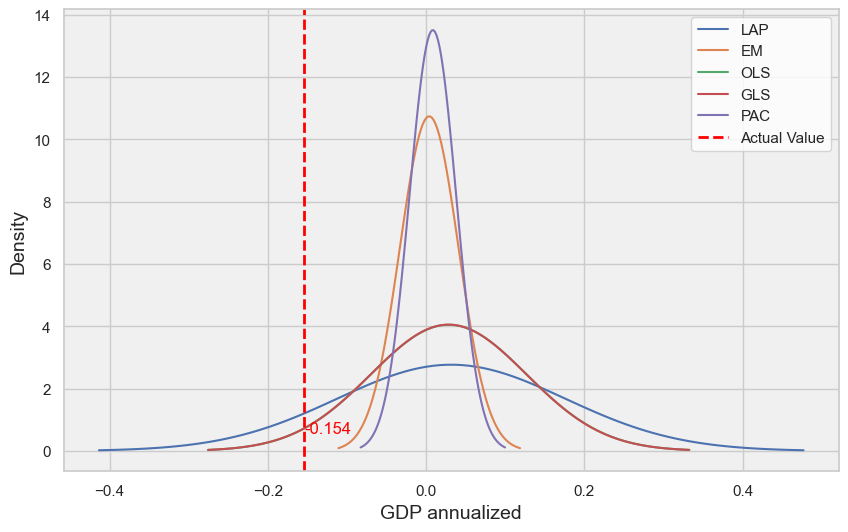

In [61]:
#Plot Vintage 2020-Q2
vintage = np.datetime64('2020-04-01')
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the predictive densities for each model
for i, (beta, beta_name) in enumerate(zip(betas, beta_names)):
    mse_list, predictive_densities = recursive_poos(df_complete, horizon, beta)

    if predictive_densities:
        predictive_density = predictive_densities[0]
        y = np.linspace(predictive_density.ppf(0.001), predictive_density.ppf(0.999), 100)
        density = predictive_density.pdf(y)
        # Plot the density
        ax.plot(y, density, label=f'{beta_name}')

# Plot the actual value of y as a vertical line
actual_value = df.loc[vintage, 'GDPgrowth(annualized)']
ax.axvline(actual_value, color='red', linestyle='--', linewidth=2, label='Actual Value')
ax.text(actual_value, 0.95, f'{actual_value:.3f}', color='red', fontsize=12,
        ha='left', va='top')
ax.set_facecolor('#f0f0f0')
# Set the plot title and labels
#ax.set_title(f'Predictive Densities for Vintage 2020-Q2', fontsize=16)
ax.set_xlabel('GDP annualized', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.legend()
plt.show()